In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!kaggle datasets download robgonsalves/impressionistlandscapespaintings

Dataset URL: https://www.kaggle.com/datasets/robgonsalves/impressionistlandscapespaintings
License(s): CC-BY-SA-4.0
100% 1.00G/1.00G [00:59<00:00, 21.7MB/s]
100% 1.00G/1.00G [00:59<00:00, 18.1MB/s]


In [ ]:
#!/bin/bash
!kaggle datasets download ashwingupta3012/human-faces

Dataset URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces
License(s): CC0-1.0
100% 1.82G/1.82G [01:39<00:00, 21.1MB/s]
100% 1.82G/1.82G [01:39<00:00, 19.7MB/s]


In [ ]:
!unzip human-faces.zip -d /content/drive/MyDrive/face-dataset/human-faces

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2911).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2912).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2913).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2914).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2915).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2916).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2917).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2918).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2919).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (292).jpg  
  inflating: /content/drive/MyDrive/face-dataset/human-faces/Humans/1 (2920).jpg  
  inflating: /content/drive/MyDrive/f

In [ ]:
!unzip impressionistlandscapespaintings.zip -d /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024/a-y-jackson_a-copse-evening-1918.jpg  
  inflating: /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024/a-y-jackson_early-spring-quebec-1923.jpg  
  inflating: /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024/a-y-jackson_first-snow-algoma-country-1920.jpg  
  inflating: /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024/a-y-jackson_frozen-lake-early-spring-algonquin-park-1914.jpg  
  inflating: /content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024/a-y-jackson_maple-woods-algoma-1920.jpg  
  i

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import glob
from PIL import Image

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

def load_image(img_path, img_size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(img_size)
    img = np.array(img)
    # Ensure the image has 3 channels (RGB)
    if img.ndim == 2:  # If grayscale, convert to RGB
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[-1] > 3:  # If RGBA, convert to RGB
        img = img[:, :, :3]
    # Normalize pixel values to [-1, 1]
    img = (img - 127.5) / 127.5
    return img

def preprocess_images(directory, img_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filtering
            img_path = os.path.join(directory, filename)
            img = load_image(img_path, img_size)
            images.append(img)
    return np.array(images)

def load_dataset(content_dir, style_dir, img_size=(128, 128)):
    content_images = preprocess_images(content_dir, img_size)
    style_images = preprocess_images(style_dir, img_size)
    return content_images, style_images

In [ ]:
def build_generator():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.LeakyReLU()(down2)

    # Bottleneck
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(bottleneck)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up1)
    up2 = layers.ReLU()(up2)

    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(up2)

    return tf.keras.Model(inputs, outputs)


In [ ]:
def build_discriminator():
    inputs = layers.Input(shape=(128, 128, 3))

    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = layers.LeakyReLU()(down3)

    patch_out = layers.Conv2D(1, (4, 4), padding='same')(down3)

    return tf.keras.Model(inputs, patch_out)


In [ ]:
# Loss function for real and fake images
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity=5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))


In [ ]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g  # Photo to painting
        self.generator_f = generator_f  # Painting to photo
        self.discriminator_x = discriminator_x  # Real or fake photo
        self.discriminator_y = discriminator_y  # Real or fake painting

    def compile(self, gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data  # Photos and paintings

        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            fake_y = self.generator_g(real_x, training=True)
            # Generator F translates Y -> X
            fake_x = self.generator_f(real_y, training=True)

            # Cycle consistency
            cycled_x = self.generator_f(fake_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            # Identity mapping
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            # Discriminator output
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Generator and discriminator losses
            gen_g_loss = generator_loss(disc_fake_y)
            gen_f_loss = generator_loss(disc_fake_x)
            cycle_loss = self.cycle_loss_fn(real_x, cycled_x) + self.cycle_loss_fn(real_y, cycled_y)
            total_gen_g_loss = gen_g_loss + cycle_loss + self.identity_loss_fn(real_y, same_y)
            total_gen_f_loss = gen_f_loss + cycle_loss + self.identity_loss_fn(real_x, same_x)

            disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # Apply gradients to the generators and discriminators
        grads_gen_g = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        grads_gen_f = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        grads_disc_x = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        grads_disc_y = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.gen_g_optimizer.apply_gradients(zip(grads_gen_g, self.generator_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(grads_gen_f, self.generator_f.trainable_variables))
        self.disc_x_optimizer.apply_gradients(zip(grads_disc_x, self.discriminator_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(grads_disc_y, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }


In [ ]:
# Load the datasets
content_images, style_images = load_dataset('/content/drive/MyDrive/face-dataset/human-faces/Humans', '/content/drive/MyDrive/face-dataset/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024')

min_samples = min(content_images.shape[0], style_images.shape[0])
content_images = content_images[:min_samples]
style_images = style_images[:min_samples]

# **Convert images to float32**
content_images = content_images.astype('float32')
style_images = style_images.astype('float32')

# Create generators and discriminators
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Instantiate the CycleGAN model
cycle_gan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

# Compile the model
cycle_gan.compile(
    gen_g_optimizer=Adam(2e-4, beta_1=0.5),
    gen_f_optimizer=Adam(2e-4, beta_1=0.5),
    disc_x_optimizer=Adam(2e-4, beta_1=0.5),
    disc_y_optimizer=Adam(2e-4, beta_1=0.5),
    cycle_loss_fn=cycle_consistency_loss,
    identity_loss_fn=identity_loss
)

# Train the model (with dataset batching)
history = cycle_gan.fit(tf.data.Dataset.from_tensor_slices((content_images, style_images)).batch(5), epochs=15)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - disc_x_loss: 1.2447 - disc_y_loss: 1.2535 - gen_f_loss: 4.7419 - gen_g_loss: 4.8758
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 59ms/step - disc_x_loss: 1.1663 - disc_y_loss: 1.2404 - gen_f_loss: 4.1580 - gen_g_loss: 4.1981
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - disc_x_loss: 1.1570 - disc_y_loss: 1.2304 - gen_f_loss: 3.9068 - gen_g_loss: 3.9341
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - disc_x_loss: 1.1476 - disc_y_loss: 1.2312 - gen_f_loss: 3.7503 - gen_g_loss: 3.7727
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - disc_x_loss: 1.1368 - disc_y_loss: 1.2472 - gen_f_loss: 3.6343 - gen_g_loss: 3.6170
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - disc_x_loss: 1.1335 - disc_y_loss: 1.2409 - gen_f_loss: 3.5425 - gen_g_loss: 3.5173
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - disc_x_loss: 1.1393 - disc_y_loss: 1.2414 - gen_f_loss: 3.4652 - gen_g_loss: 3.4485
Epoch 

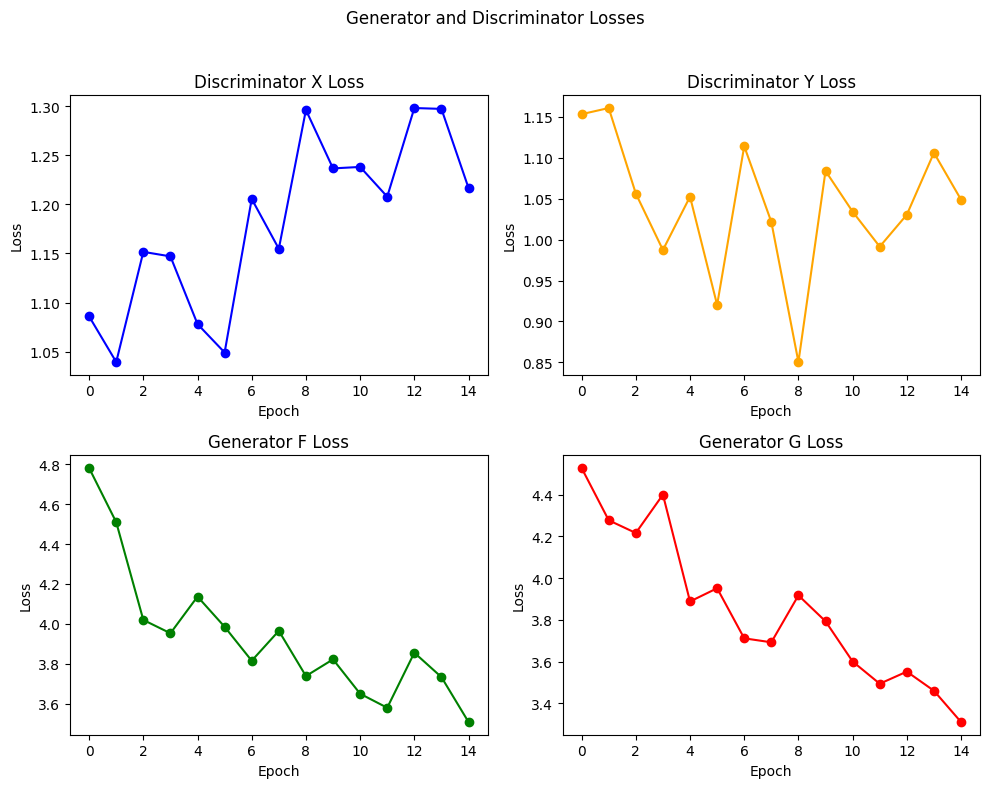

In [ ]:
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Generator and Discriminator Losses")

# Plot disc_x_loss
axs[0, 0].plot(history.history['disc_x_loss'], marker='o', color='blue')
axs[0, 0].set_title("Discriminator X Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")

# Plot disc_y_loss
axs[0, 1].plot(history.history['disc_y_loss'], marker='o', color='orange')
axs[0, 1].set_title("Discriminator Y Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")

# Plot gen_f_loss
axs[1, 0].plot(history.history['gen_f_loss'], marker='o', color='green')
axs[1, 0].set_title("Generator F Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")

# Plot gen_g_loss
axs[1, 1].plot(history.history['gen_g_loss'], marker='o', color='red')
axs[1, 1].set_title("Generator G Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
plt.show()


In [ ]:
generator_g.save_weights('/content/drive/MyDrive/face-dataset/cycle_gan.weights.h5')

# Testing

In [ ]:
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """Load and preprocess a single image."""
    image = Image.open(image_path).resize(img_size)
    image = np.array(image) / 127.5 - 1  # Normalize to [-1, 1]+
    return np.expand_dims(image, axis=0)  # Add batch dimension

def generate_and_save_images(model, test_input, path='output_image.jpg'):
    """Generate images using the model and save the output."""
    prediction = model(test_input, training=False)
    plt.imshow((prediction[0] * 0.5 + 0.5))  # De-normalize [-1, 1] to [0, 1]
    plt.axis('off')
    plt.savefig(path)
    plt.show()


In [ ]:
def build_generator():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.LeakyReLU()(down2)

    # Bottleneck
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(bottleneck)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up1)
    up2 = layers.ReLU()(up2)

    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(up2)

    return tf.keras.Model(inputs, outputs)


In [ ]:
gg = build_generator()
gg.load_weights('/content/drive/MyDrive/face-dataset/cycle_gan.weights.h5')

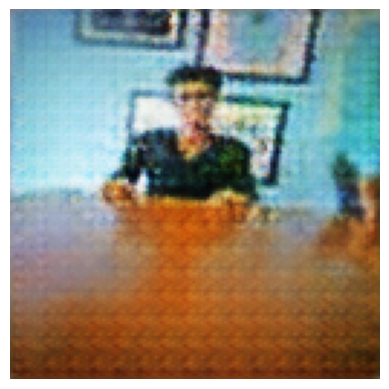

In [ ]:
# Generate a new stylized image
sample_content_image_path = '/content/drive/MyDrive/WhatsApp Image 2024-11-16 at 12.50.52_328881a4.jpg'  # Update with your image path
sample_content_image = load_and_preprocess_image(sample_content_image_path)

# Use the generator to create a stylized output
generate_and_save_images(gg, sample_content_image, path='output_image.jpg')
